# 1. Tipos de fronteras en Clasificación

Generación de los conjuntos

In [1]:
from sklearn.utils import check_random_state
import numpy as np

n_samples=500
mean = (0,-4)
C = np.array([[0.3, 0.1], [0.1, 1.5]])
np.random.seed(14)
datos1 = np.random.multivariate_normal(mean, C, n_samples)
outer_circ_x = np.cos(np.linspace(0, np.pi, n_samples))*3
outer_circ_y = np.sin(np.linspace(0, np.pi, n_samples))*3
datos2 = np.vstack((outer_circ_x,outer_circ_y)).T

generator = check_random_state(64)
datos2 += generator.normal(scale=0.3, size=datos2.shape)

**a)** Construya el conjunto de datos (dataset) común con los dos conjuntos generados. Luego se realiza un shift desde el conjunto 2 al 1, esto se puede ver en la imagen anterior, donde el conjunto de color naranjo (media luna) tiene puntos azules a la derecha pertenecientes al otro conjunto, esto es con el mismo propósito de trabajar con un dataset no ideal. Determine cuántos registros contiene cada conjunto y visualícelos.


In [2]:
import matplotlib.pyplot as plt

X = np.concatenate((datos1, datos2), axis=0)
n = 20 #ruido/noise
y1 = np.zeros(datos1.shape[0]+n)
y2 = np.ones(datos2.shape[0]-n)
y = np.concatenate((y1,y2),axis=0)

def visualize_border(model,x,y,title=""):
    fig = plt.figure(figsize=(12,6))
    plt.scatter(x[:,0], x[:,1], s=50, c=y, cmap=plt.cm.winter)
    h = .02 # step size in the mesh
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)
    plt.title(title)
    plt.show()

**(b)** Entrene el clasificador Linear Discriminant Analysis (LDA) y visualice la frontera de decisión que define este algoritmo. Analice cualitativamente lo que observa.

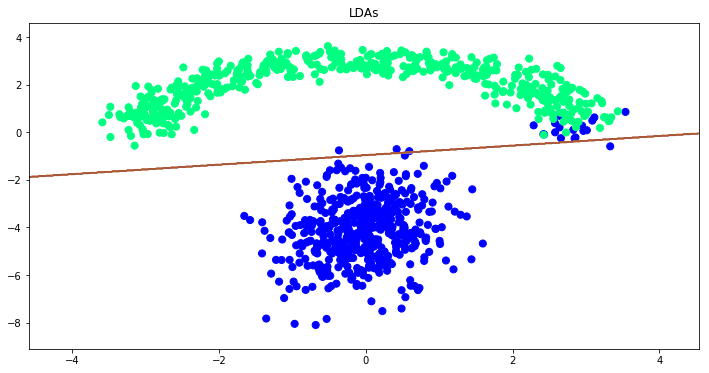

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
model_LDA = LDA()
model_LDA.fit(X,y)
visualize_border(model_LDA,X,y,"LDAs")

**c)** Entrene el clasificador Quadratic Discriminant Analysis (QDA) y visualice la frontera de decisión que define este algoritmo. Analice cualitativamente lo que observa y compare con LDA, en qué difieren y en qué se asemejan ¿Qué distribucién de probabilidad asumen cada uno?

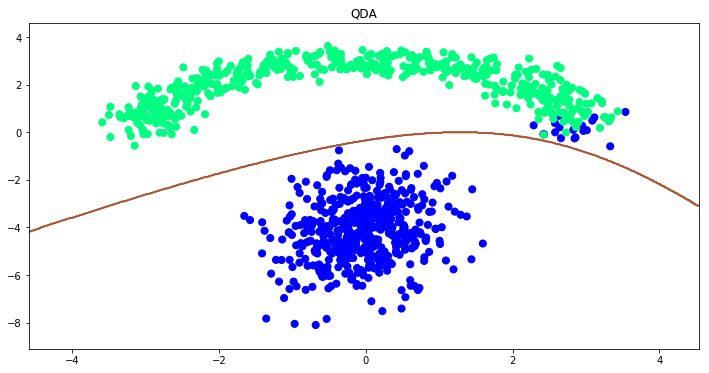

In [4]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
model_QDA = QDA()
model_QDA.fit(X,y)
visualize_border(model_QDA,X,y,"QDA")

**d)** Compare cuantitativamente los clasificadores LDA Y QDA en este dataset sintético mediante la métrica de error de clasificación.

In [5]:
from sklearn.metrics import accuracy_score

y_pred_LDA = model_LDA.predict(X)
y_pred_QDA = model_QDA.predict(X)
print("Miss Classification Loss for LDA: %f"%(1-accuracy_score(y, y_pred_LDA)))
print("Miss Classification Loss for QDA: %f"%(1-accuracy_score(y, y_pred_QDA)))

Miss Classification Loss for LDA: 0.022000
Miss Classification Loss for QDA: 0.020000


**e)** Construya una función que entrene/ajuste un modelo de Regresión Logística Regularizado (utilizando como penalizador la norma $l_2$), experimente con distintos valores del parámetro de regularización mediante el gráfico interactivo. Explique el significado y efecto esperado de este parámetro. Analice cualitativamente lo observado.

In [11]:
from ipywidgets import interactive
def visualize_border_interactive(param):
    model = train_model(param)
    visualize_border(model,X,y)

from sklearn.linear_model import LogisticRegression as LR
def train_model(param):
    model=LR() #define your model
    model.set_params(C=param,penalty='l2')
    model.fit(X,y)
    return model

p_min = 0.001
p_max = 1
interactive(visualize_border_interactive,param=(p_min,p_max, 0.001))

interactive(children=(FloatSlider(value=0.5, description='param', max=1.0, min=0.001, step=0.001), Output()), _dom_classes=('widget-interact',))

# 2. Análisis de audios como datos brutos

# 3. Análisis de emociones en tweets

**a)** Construya un dataframe con los datos a analizar. Determine cuántas clases existen, cuántos registros por clase y describa el dataset.

In [1]:
import pandas as pd
tweets = pd.read_csv('./data/text_emotion.csv')
tweets.head()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


In [2]:
clases = pd.DataFrame(tweets['sentiment'].value_counts().reset_index())
clases.columns = ["sentiment", "count"]
clases

,sentiment,count
0,neutral,8638
1,worry,8459
2,happiness,5209
3,sadness,5165
4,love,3842
5,surprise,2187
6,fun,1776
7,relief,1526
8,hate,1323
9,empty,827


El dataset cuenta con cuatro columnas, las que corresponden a el id del tweet, el autor y el contenido de este, junto con el sentimiento asociado al contenido.
Los sentimientos encontrados son 13, contando "neutral" como uno de ellos.

**b)** Construya un conjunto de entrenamiento y otro de pruebas, a través de una máscara aleatoria, para verificar los resultados de los algoritmos.

La máscara se aplicará después de pre-procesar el dataset y antes de entrenar el clasificador

In [3]:
import numpy as np
np.random.seed(14)
msk = np.random.rand(len(tweets)) < 0.8

**c)** Implemente y explique un pre-procesamiento para los tweets para dejarlos en un formato estándarizado en el cual se podrán trabajar.

In [4]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import nltk
import re

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/jupy/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/jupy/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
df = tweets.copy()
df.drop(['tweet_id','author'],axis=1,inplace=True)

ps = PorterStemmer()

df['content'] = df['content'].apply(lambda x: word_tokenize(re.sub(r"[^a-z\s]+", '', x.lower())))
df['content'] = df['content'].apply(lambda x: [ps.stem(w) for w in x if w not in stopwords.words('english')])
df.head()

,sentiment,content
0,empty,"[tiffanylu, know, listenin, bad, habit, earlie..."
1,sadness,"[layin, n, bed, headach, ughhhhwaitin, call]"
2,sadness,"[funer, ceremonygloomi, friday]"
3,enthusiasm,"[want, hang, friend, soon]"
4,neutral,"[dannycastillo, want, trade, someon, houston, ..."


**d)** Haga una reducción binaria al problema, para trabajarlo como un problema de clasificación de dos clases. Para esto, agrupe las distintas emociones como positivas y negativas (defina un criterio), se recomienda codificar las clases como +1 y −1 respectivamente. Recuerde tener presente que el desbalanceo de los datos puede afectar considerablemente al modelo.

In [6]:
pos = ['happiness', 'love', 'surprise', 'fun', 'relief', 'enthusiasm']
df['clase'] = df['sentiment'].apply(lambda x: 1 if x in pos else -1)
print(df['clase'].value_counts())
df.head()

-1    24701
 1    15299
Name: clase, dtype: int64


,sentiment,content,clase
0,empty,"[tiffanylu, know, listenin, bad, habit, earlie...",-1
1,sadness,"[layin, n, bed, headach, ughhhhwaitin, call]",-1
2,sadness,"[funer, ceremonygloomi, friday]",-1
3,enthusiasm,"[want, hang, friend, soon]",1
4,neutral,"[dannycastillo, want, trade, someon, houston, ...",-1


Ahora se hace la separación de test - train

In [7]:
df_train = df[msk]
df_test = df[~msk]

**e)** Construir un clasificador que determine automáticamente la polaridad de un trozo de texto.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def tokenizr(tokens):
    return tokens

vectorizer = CountVectorizer(tokenizer=tokenizr, lowercase=False)

X_train = vectorizer.fit_transform(df_train['content'])
X_test = vectorizer.transform(df_test['content'])


**f)** Entrene y compare al menos 5 de los diferentes clasificadores vistos en clases para clasificación binaria (por ejemplo: Navie Bayes, Multinomial Naive Bayes, LDA, QDA, Regresión logística, SVM y Arboles de decisión) sobre el conjunto de entrenamiento verificando su desempeño sobre ambos conjuntos (entrenamiento y de pruebas), construyendo un gráfico resumen del error de éstos.

In [ ]:
from sklearn.naive_bayes import BernoulliNB
nb_model = BernoulliNB()
nb_model.fit(X_train, df_train['clase'])

nb_score_train = nb_model.score(X_train, df_train['clase'])
nb_score_test = nb_model.score(X_test, df_test['clase'])

print("NB Train score %f"%nb_score_train)
print("NB Test score %f"%nb_score_test)

NB Train score 0.839139
NB Test score 0.697582


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train.toarray(), df_train['clase'])

lda_score_train = lda_model.score(X_train, df_train['clase'])
lda_score_test = lda_model.score(X_test, df_test['clase'])

print("NB Train score %f"%lda_score_train)
print("NB Test score %f"%lda_score_test)

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda_model = QuadraticDiscriminantAnalysis()
qda_model.fit(X_train.toarray(), df_train['clase'])

qda_score_train = qda_model.score(X_train, df_train['clase'])
qda_score_test = qda_model.score(X_test, df_test['clase'])

print("NB Train score %f"%qda_score_train)
print("NB Test score %f"%qda_score_test)

In [ ]:
from sklearn.svm import SVC
svm_model = SVC()
svm_model.fit(X_train.toarray(), df_train['clase'])

svm_score_train = svm_model.score(X_train, df_train['clase'])
svm_score_test = svm_model.score(X_test, df_test['clase'])

print("NB Train score %f"%svm_score_train)
print("NB Test score %f"%svm_score_test)